In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


2024-01-05 15:31:17.823 | DEBUG    | incision_detection_mmdet:<module>:19 - 1.12.0a0+8a1a93a
2024-01-05 15:31:17.824 | DEBUG    | incision_detection_mmdet:<module>:24 - mmdet.version=2.25.0
2024-01-05 15:31:17.825 | DEBUG    | incision_detection_mmdet:<module>:29 - 11.7
2024-01-05 15:31:17.826 | DEBUG    | incision_detection_mmdet:<module>:30 - GCC 9.4
2024-01-05 15:31:18.275 | DEBUG    | pigleg_cv:<module>:52 - DEVICE=None


In [2]:
!pwd

/webapps/piglegsurgery/piglegcv


In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Fri Jan  5 15:31:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:42:00.0 Off |                  N/A |
|  0%   38C    P8     9W / 250W |   2050MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
torch.__version__

'1.12.0a0+8a1a93a'

In [6]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

True

In [7]:
!ls ~/.cache/torch/hub/checkpoints/

yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth


In [8]:
# pip install mmcv-full

In [9]:
import logging
import mmcv

# logger = logging.getLogger(name='torch')
# logger.setLevel(logging.WARNING)

# print(logging.root.manager.loggerDict)

# loggers = [logging.getLogger(name=name).setLevel(logging.WARNING) for name in logging.root.manager.loggerDict]
# loggers



In [10]:
loggers = [logging.getLogger(name=name) for name in logging.root.manager.loggerDict]

In [11]:
loggers

[<Logger concurrent.futures (WARNING)>,
 <Logger concurrent (WARNING)>,
 <Logger asyncio (WARNING)>,
 <Logger tornado.access (WARNING)>,
 <Logger tornado (WARNING)>,
 <Logger tornado.application (WARNING)>,
 <Logger tornado.general (WARNING)>,
 <Logger prompt_toolkit.buffer (WARNING)>,
 <Logger prompt_toolkit (WARNING)>,
 <Logger parso.python.diff (WARNING)>,
 <Logger parso.python (WARNING)>,
 <Logger parso (WARNING)>,
 <Logger parso.cache (WARNING)>,
 <Logger pkg_resources.extern.packaging.tags (WARNING)>,
 <Logger pkg_resources.extern.packaging (WARNING)>,
 <Logger pkg_resources.extern (WARNING)>,
 <Logger pkg_resources (WARNING)>,
 <Logger IPKernelApp (DEBUG)>,
 <Logger urllib3.util.retry (WARNING)>,
 <Logger urllib3.util (WARNING)>,
 <Logger urllib3 (WARNING)>,
 <Logger urllib3.connection (WARNING)>,
 <Logger urllib3.response (WARNING)>,
 <Logger urllib3.connectionpool (WARNING)>,
 <Logger urllib3.poolmanager (WARNING)>,
 <Logger charset_normalizer (WARNING)>,
 <Logger socks (WARNI

In [12]:
from loguru import logger

# Run whole video processing

In [21]:
is_microsurgery = False
test_first_seconds = False
use_application_outputdir = False
force_tracker = False

patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "Einzel.MOV"
patch = "test_4.mp4"; n_stitches=0
# patch = "micro_01*.mp4"
# patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"; n_stitches=5
patch = "Katharina_Einzelknopfnaht"; n_stitches=3
# patch = "Johanna"
# n_stitches = 2

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
mediafile_path = img_pths[0]


# original outputdir
if use_application_outputdir:
    outputdir = list(list(Path("../piglegsurgeryweb/media/").glob(f"*/*{patch}*.zip"))[0].parent.glob("*/meta.json"))[0].parent
    outputdir = outputdir.absolute().resolve()
    outputdir
else:
    outputdir = Path("./del_test_video_output/") / mediafile_path.name

In [22]:
# list(zf.parent.glob("*"))

## Do whole processing together


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-01-05 15:37:51,182 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2024-01-05 15:37:51,206 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2024-01-05 15:37:51,207 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-01-05 15:37:51,208 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-01-05 15:37:51,445 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 320, 1, 

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2024-01-05 15:37:53,468 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2024-01-05 15:37:53,493 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2024-01-05 15:37:53,494 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-01-05 15:37:53,494 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-01-05 15:37:53,698 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([5, 320, 1, 

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch_2.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_b

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

main_report: Video file del_test_video_output/Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht.mp4/__cropped.mp4 is processed!


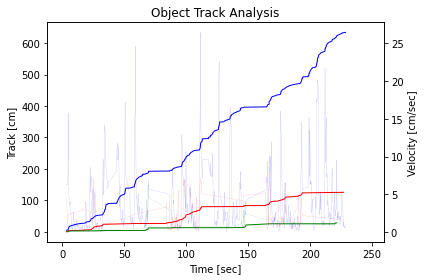

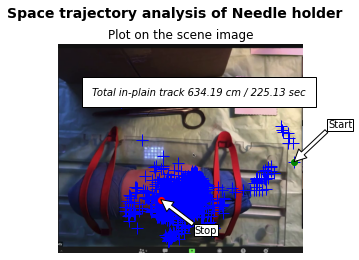

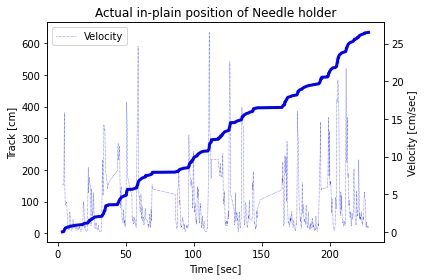

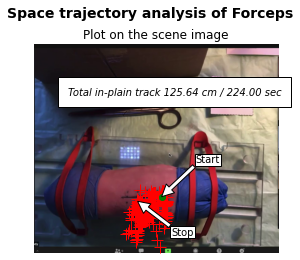

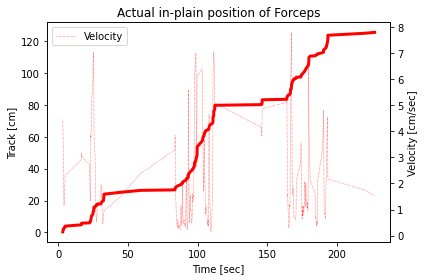

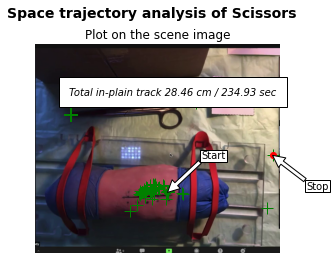

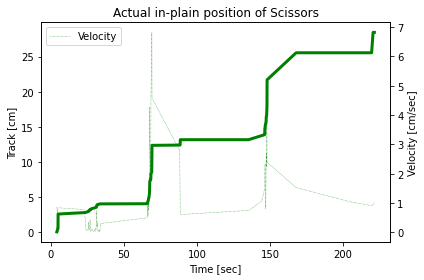

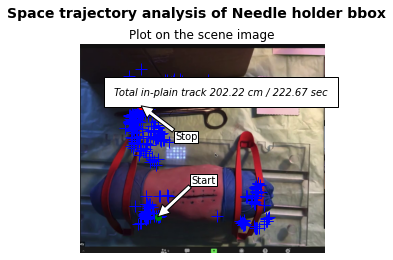

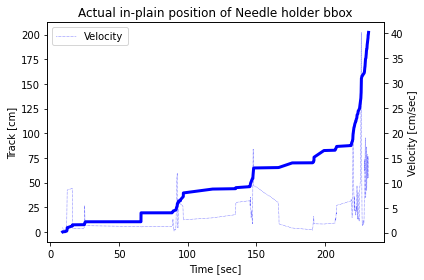

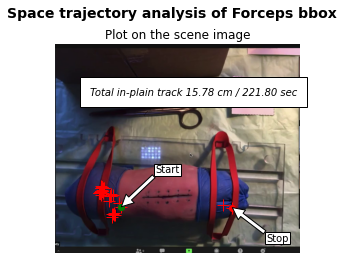

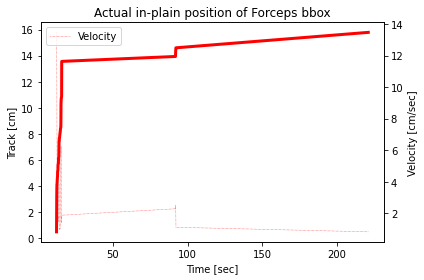

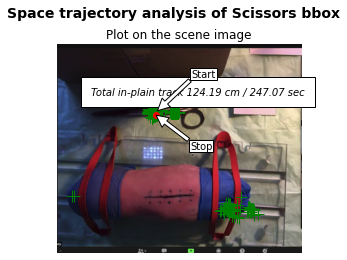

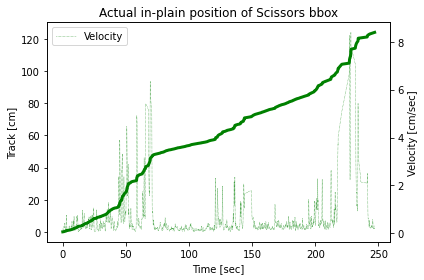

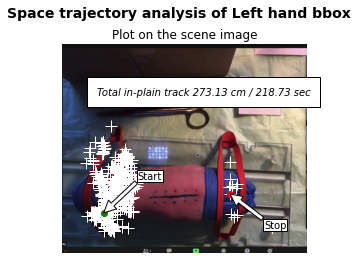

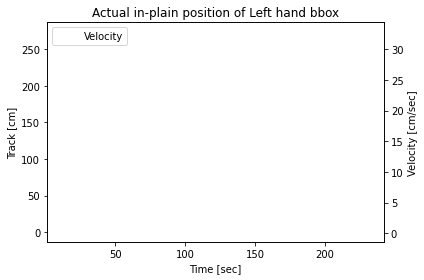

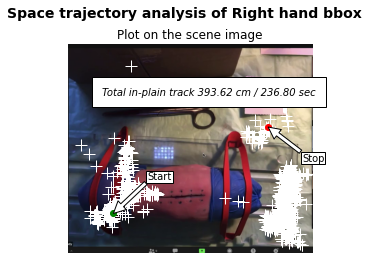

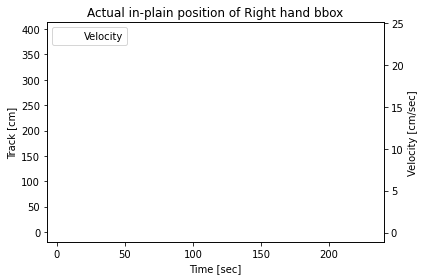

In [23]:
dcv = pigleg_cv.DoComputerVision(
    mediafile_path,
    outputdir,
    test_first_seconds=test_first_seconds,
    is_microsurgery=is_microsurgery,
    force_tracker=force_tracker
)
dcv.run()

In [17]:
logger

<loguru.logger handlers=[]>

In [10]:
from loguru import logger
logger.debug("ahoj")

2024-01-05 13:55:33.732 | DEBUG    | __main__:<cell line: 2>:2 - ahoj


In [12]:
logger.warning("asdf")

2024-01-05 13:55:42.563 | WARNING  | __main__:<cell line: 1>:1 - asdf


In [12]:
# report_data = dcv.make_report()